## Error Mitigation for Quantum Neural Networks on IBM Quantum Devices

### Overview

This tutorial covers the setup and implementation of error mitigation techniques for Qiskit's primitives when building Quantum Neural Networks (QNNs) using **sQUlearn**. We will first train a simple QNN on a noise-free, ideal simulator to fit a parabolic dataset. Next, we’ll demonstrate how to configure the `Executor` class to connect to IBM Quantum devices. Before proceeding, ensure you have an IBM Quantum account with access to IBM devices. If needed, refer to [IBM Quantum Account Management](https://docs.quantum.ibm.com/guides/setup-channel) for guidance on registering and configuring your account.

Due to the longer queuing times and associated costs of running circuits on real quantum hardware, we suggest using this notebook primarily as a demonstration of error mitigation setup rather than executing it directly on IBM devices. However, it will prepare you to set up error mitigation for real experiments should the need arise.

In this notebook, we will explore various error mitigation strategies for the `EstimatorV2` and `SamplerV2` primitive used to performe calculations on IBM Quantum.

### Library Imports

To begin, we’ll import the essential libraries for this tutorial. These include `qiskit-ibm-runtime` for connecting to IBM Quantum devices. We’ll also use the `squlearn` library to build and train the QNN for both ideal and mitigated scenarios.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime.fake_provider import FakeBelemV2

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam

### Set-up of the QNN

We first set up the data encoding circuit for the QNN. Here, we utilize the `ChebyshevPQC` encoding circuit with 2 qubits and 2 layers to keep runtime low.

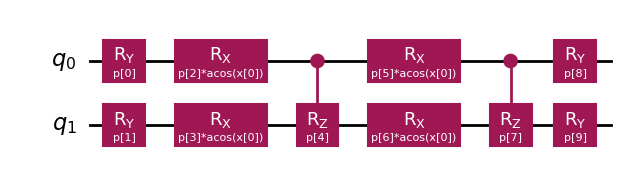

In [2]:
nqubits = 2
pqc = ChebyshevPQC(num_qubits=nqubits, num_layers=2)
pqc.draw("mpl", num_features=1)

We utilize the parameterized summation over Z Pauli matrices as the observable: $\hat{O} = \hat{I}\alpha + \sum_i\hat{Z}_i \beta_i$

In [3]:
op = SummedPaulis(nqubits)
print(op)

SparsePauliOp(['II', 'IZ', 'ZI'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2])])


#### Configuring the Quantum Neural Network (QNN)

Lastly, we configure the Quantum Neural Network (QNN) using the `QNNRegressor` class from the **squlearn** library. In this setup, we initialize the QNN with randomized weights, apply the L2 Loss (also known as Squared Loss), and utilize the Adam optimization routine with a learning rate of 0.1. Notably, during training, the QNN operates on a noise-free simulation based on the **PennyLane** framework.


In [4]:
# Randomly initialize parameters of the QNN
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.ones(op.num_parameters)

qnn_simulator = QNNRegressor(
    pqc,
    op,
    Executor(),
    SquaredLoss(),
    Adam({"lr": 0.1, "maxiter": 100}),
    param_ini,
    param_op_ini,
)

### Training of the QNN with a noise free simulator

In this cell, we set-up the data `x_train` and `y_train` for training the QNN. The values are obtained by calculating the values of the simple parametric function $f(x) = x^2$ with the `square` function of `numpy`.

In [5]:
# Data that is inputted to the QNN
x_train = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y_train = np.square(x_train)

Afterwards, we train the QNN by calling the `fit` method of the `QNNRegressor` class.

In [6]:
qnn_simulator.fit(x_train.reshape(-1, 1), y_train)

fit: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


The finial parameters of the encoding circuit and the observable are displayed in the output of the following cell.

In [7]:
print("Result encoding parameters:", qnn_simulator.param)
print("Result observable parameters:", qnn_simulator.param_op)

Result encoding parameters: [-0.49160402  1.64667556 -0.26294504  5.06115208 -2.05030927  0.06618495
  4.34584539  3.78529289  3.44408409 -0.59021673]
Result observable parameters: [0.77280427 1.01968289 0.29886875]


Following the QNN's training, we proceed to compute model inferences and visualize the results. The QNN model generates the parabolic output, affirming the successful training of the QNN.


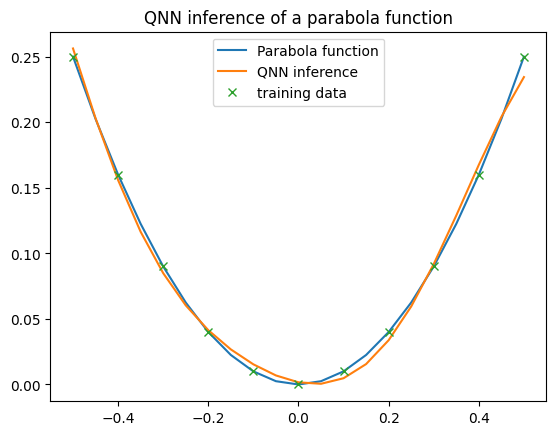

In [8]:
x = np.arange(np.min(x_train), np.max(x_train) + 0.05, 0.05)
y = qnn_simulator.predict(x.reshape(-1, 1))  # function for evaluating the prediction of the QNN
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference of a parabola function")
plt.show()

### Evaluating the QNN on the IBM Backend with Error Mitigation

Next, we assess the QNN’s performance on real IBM backends by utilizing the Qiskit runtime environment. Here, we assume an IBM Quantum setup is already configured, allowing `QiskitRuntimeService` to be called without requiring a token. We initiate a session that is shared across different executor instances to ensure that all evaluations in this notebook are executed within a single session, thereby avoiding queuing delays.

By default, this notebook is configured to use a fake backend to prevent incurring costs on IBM Quantum. Note, however, that error mitigation strategies are automatically disabled by Qiskit when running on a local simulator. The results presented here are based on actual IBM Quantum hardware outcomes.

To switch from local simulation to execution on IBM Quantum, simply set the `local` variable to `False`.

In [9]:
local = True
if local:
    execution = FakeBelemV2()
else:
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    print("Selected Backend:", backend.name)
    execution = Session(backend=backend)

### Without Error Mitigation

In our first example, we disable all error mitigation techniques and test the QNN on the IBM backend. Here, we observe that the QNN’s output differs noticeably from the output of the noise-free simulator.

Primarily, the QNN’s output is no longer smooth; it displays zigzag patterns. This is because the QNN is evaluated with a limited number of shots, introducing sampling noise into each QNN output. Additionally, the shape of the QNN function changes, as if an offset has been added. Upon closer inspection, we find that this offset is not consistent.

These differences occur because the applied quantum gates are imperfect; their inherent error rates affect the QNN’s overall shape. A notable way to mitigate this issue is by training the QNN directly on the same IBM backend used for evaluation!

c:\Users\MOW-DK\dev\squlearn\.venv\lib\site-packages\qiskit\primitives\backend_estimator_v2.py:273: ComplexWarning: Casting complex values to real discards the imaginary part
  evs[index] += expval * coeff


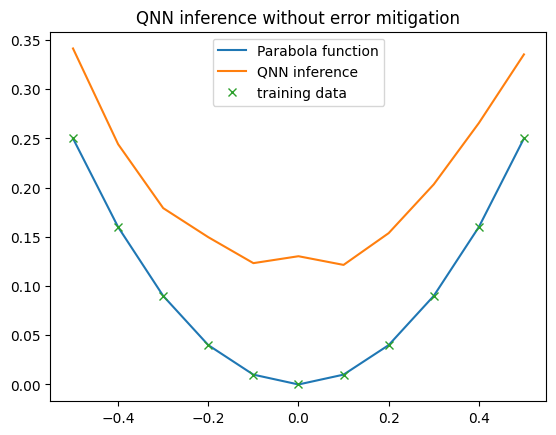

In [10]:
executor_no_mitigation = Executor(execution, log_file="qnn.log", shots=10000)

qnn_backend = QNNRegressor(
    pqc,
    op,
    executor_no_mitigation,
    SquaredLoss(),
    Adam(),
    qnn_simulator.param,
    qnn_simulator.param_op,
    caching=False,
    pretrained=True,
    primitive="estimator",
)
x = np.arange(np.min(x_train), np.max(x_train) + 0.1, 0.1)
y = qnn_backend.predict(x.reshape(-1, 1))
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference without error mitigation")
plt.show()

### Dynamic Decoupling and TREX

In this example, we demonstrate how to use Dynamic Decoupling and Twirled Readout Error Extinction (TREX) to enhance QNN performance on noisy hardware. The options for error mitigation can be configured through the `estimator_options` in the executor, which allows customization of the settings for the `EstimatorV2` primitive used by squlearn under the hood.

**Dynamic Decoupling** is a technique that applies carefully timed sequences of pulses to reduce errors caused by environmental noise and gate imperfections during idle times on qubits. 

**TREX (Twirled Readout Error Extinction)** is a method that reduces readout errors by applying randomized transformations to measurement outcomes, making the errors more uniform and thus easier to correct.

More details on various error mitigation and suppression strategies are available in the [Qiskit documentation](https://docs.quantum.ibm.com/guides/error-mitigation-and-suppression-techniques).


c:\Users\MOW-DK\dev\squlearn\.venv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'measure_mitigation': True, 'measure_noise_learning': {'num_randomizations': 32, 'shots_per_randomization': 1000}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\MOW-DK\dev\squlearn\.venv\lib\site-packages\qiskit\primitives\backend_estimator_v2.py:273: ComplexWarning: Casting complex values to real discards the imaginary part
  evs[index] += expval * coeff


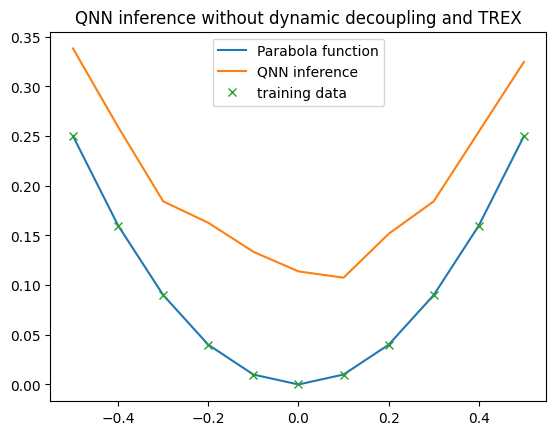

In [11]:
executor_dd_trex = Executor(execution, log_file="qnn.log", shots=10000)

# Dynamical decoupling
executor_dd_trex.estimator_options.dynamical_decoupling.enable = True
executor_dd_trex.estimator_options.dynamical_decoupling.sequence_type = "XpXm"

# Twirled readout error extinction (TREX)
executor_dd_trex.estimator_options.resilience.measure_mitigation = True
executor_dd_trex.estimator_options.resilience.measure_noise_learning.num_randomizations = 32
executor_dd_trex.estimator_options.resilience.measure_noise_learning.shots_per_randomization = 1000

qnn_backend = QNNRegressor(
    pqc,
    op,
    executor_dd_trex,
    SquaredLoss(),
    Adam(),
    qnn_simulator.param,
    qnn_simulator.param_op,
    caching=False,
    pretrained=True,
    primitive="estimator",
)

y = qnn_backend.predict(x.reshape(-1, 1))
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference without dynamic decoupling and TREX")
plt.show()

#### Dynamic Decoupling and Zero-Noise Extrapolation (ZNE) for Error Mitigation

In this example, we employ Zero-Noise Extrapolation (ZNE) to mitigate errors in the computed expectation values. ZNE works by running quantum circuits with artificially increased noise levels and then extrapolating the results to approximate a noise-free scenario.

Qiskit’s implementation of zero-noise extrapolation offers various options for fine-tuning the error mitigation process. For more details, refer to the [Qiskit documentation on ZNE](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ZneOptions).

In this case, ZNE did not perfectly align the QNN’s output with the noise-free results, though it brought the QNN’s output shape closer to that of the noise-free simulator. However, it’s worth noting that the noise levels increased due to the extrapolation steps involved in ZNE.

c:\Users\MOW-DK\dev\squlearn\.venv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'resilience': {'zne_mitigation': True, 'zne': {'noise_factors': (1.0, 3.0, 5.0), 'extrapolator': 'linear'}}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\MOW-DK\dev\squlearn\.venv\lib\site-packages\qiskit\primitives\backend_estimator_v2.py:273: ComplexWarning: Casting complex values to real discards the imaginary part
  evs[index] += expval * coeff


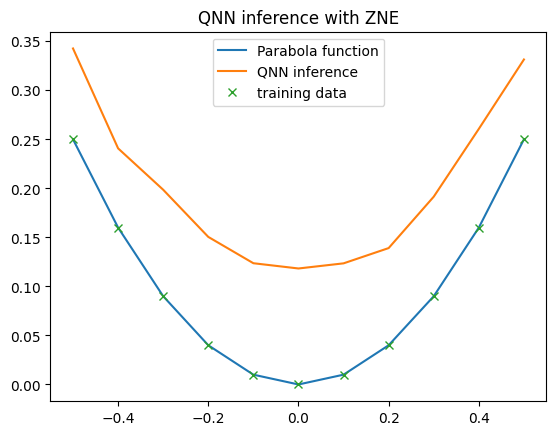

In [12]:
executor_zne = Executor(execution, log_file="qnn.log", shots=10000)
# Configuration for Zero Noise Extrapolation
executor_zne.estimator_options.resilience.zne_mitigation = True
executor_zne.estimator_options.resilience.zne.noise_factors = (1, 3, 5)
executor_zne.estimator_options.resilience.zne.extrapolator = "linear"

qnn_backend = QNNRegressor(
    pqc,
    op,
    executor_zne,
    SquaredLoss(),
    Adam(),
    qnn_simulator.param,
    qnn_simulator.param_op,
    caching=False,
    pretrained=True,
    primitive="estimator",
)

y = qnn_backend.predict(x.reshape(-1, 1))
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference with ZNE")
plt.show()

### Assessing the QNN on IBM Quantum Using the Sampler Primitive

Last, we assess the QNN’s performance by utilizing the Sampler primitive. The Sampler primitive gathers probability distributions from the encoding circuits, allowing the QNN to compute expectation values of observables based on these probabilities.

The Sampler primitive also supports various error mitigation strategies, which can be configured in the `Executor` via `sampler_options`, similar to the `estimator_options` discussed above.

In this example, we again apply Dynamic Decoupling as an error mitigation technique and ensure the QNN uses the Sampler primitive by specifying `primitive="sampler"` during QNN initialization.

c:\Users\MOW-DK\dev\squlearn\.venv\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
c:\Users\MOW-DK\dev\squlearn\.venv\lib\site-packages\qiskit\primitives\containers\bit_array.py:610: ComplexWarning: Casting complex values to real discards the imaginary part
  arr[index] += expval * coeff


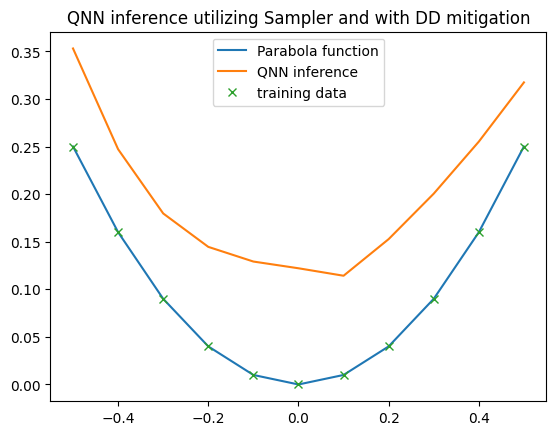

In [13]:
executor_sampler = Executor(execution, log_file="qnn.log", shots=10000)

executor_sampler.sampler_options.dynamical_decoupling.enable = True
executor_sampler.sampler_options.dynamical_decoupling.sequence_type = "XpXm"

qnn_backend = QNNRegressor(
    pqc,
    op,
    executor_sampler,
    SquaredLoss(),
    Adam(),
    qnn_simulator.param,
    qnn_simulator.param_op,
    caching=False,
    pretrained=True,
    primitive="sampler",
)

y = qnn_backend.predict(x.reshape(-1, 1))
plt.plot(x, np.square(x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference utilizing Sampler and with DD mitigation")
plt.show()

In the last step, we manually close the session in order to terminate the (potentially costly) usage of the quantum computing resource.

In [14]:
if isinstance(execution, Session):
    execution.close_session()